# Self-organizing maps

A simple implementation of a self-organizing map using numpy

### What is a self-organizing map?

A self-organizing map (SOM) is a type or artificial neural network that is able to produce a low-dimensional representation of the input space through unsupervised training. Contrary to the well-known approach of error-correction learning (the one seen in the most common neural networks), SOMs apply competitive learning, where only one neuron (known as the Best Matching Unit) is activated when a sample is passed through the map.

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output
sns.set()

We'll use colors as the training data. For that, we'll use numpy's function random.randint; we'll get 100 samples of RGB colors (values ranging from 0 to 255).

In [2]:
colors = np.random.randint(0, 256, (100, 3))
# Min max normalization:
colors = (colors - colors.min()) / (colors.max() - colors.min())

Now we'll specify our SOM's shape; the ammount of connections its neurons will have depends on our training data. In this case, for RGB colors, every neuron will have 3 connections with the input, which results in 3 weights per neuron.

In [3]:
map_side = 15
_, connections = colors.shape
weight_matrix = np.random.random((map_side, map_side, connections))

And its training parameters:

In [4]:
epochs = 10000
learning_rate = 0.2
neighborhood = map_side / 2

Helper matrix

In [5]:
# We create an index matrix in order to calculate physical proximity between neurons; we do this in order to
# determine which neurons to update after every epoch; wether they are in the BMU's neighborhood or not
idx_matrix = []
for y in range(map_side):
    row = []
    for x in range(map_side):
        row.append([y, x])
    idx_matrix.append(row)
idx_matrix = np.array(idx_matrix)

## Training functions

Now we'll implement the functions needed to train our SOM

#### Best Matching Unit

In [6]:
def find_bmu(input_pattern, w_matrix):
    """
    Finds the BMU in the map for a given input pattern.
    
    """
    # First, we determine the distance from every neuron to the input pattern.
    # For that, we calculate the euclidean distance (without the square root in order to save computing power and time) between the
    # input pattern and the weight matrix:
    # Square of the difference:
    # (w_matrix - input_pattern)**2
    # Squares added:
    # np.sum(((w_matrix - input_pattern)**2), axis=2)
    # This gives us a matrix containing the distance between every neuron and the input pattern 
    distances = np.sum((w_matrix - input_pattern)**2, axis=2)
    # Second, we find the value and the position of the minimum value of the distances array using np.where
    bmu_idx = np.where(distances == distances.min())
    # We get a tuple corresponding to the coordinates of the BMU, which we convert to a numpy array
    bmu_idx = np.array(bmu_idx).ravel()
    # Now, with the BMU's coordinates, we can find its weights
    bmu = w_matrix[bmu_idx]
    
    return bmu, bmu_idx

#### Updating the learning rate

Linear descent of the learning rate thoughout the training

In [7]:
def lr_update(initial_lr, current_iteration, max_iterations):
    return initial_lr - (initial_lr / max_iterations) * current_iteration

#### Updating the neighbourhood

In [8]:
def nb_update(initial_neighborhood, current_iteration, max_iterations):
    return initial_neighborhood - (initial_neighborhood / max_iterations) * current_iteration

#### Calculating the decay

In [9]:
def lr_decay(distance_to_bmu, current_neighborhood):
    return np.exp(-distance_to_bmu / (2 * (current_neighborhood**2)))

#### Showing the output

In [10]:
def show_map(w_matrix, i):
    clear_output(wait=True)
    plt.imshow(w_matrix)
    plt.title(f'SOM after {i} epochs')
    plt.axis('off')
    plt.show()

### Training

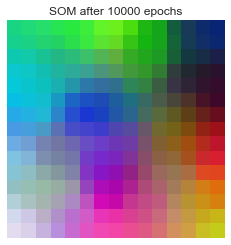

In [11]:
for epoch in range(epochs):
    # We take a sample from the dataset
    sample = colors[np.random.randint(0, 100)]

    # Then, we find the best matching unit and its index for that sample
    bmu, bmu_idx = find_bmu(sample, weight_matrix)

    # Before making any operations, we determine the learning rate and neighborhood for the current epoch
    current_lr = lr_update(learning_rate, epoch, epochs)
    current_nb = nb_update(neighborhood, epoch, epochs)

    # Now we obtain the distance between each neuron and the BMU in order to find out what neurons to update
    distances = np.sqrt(np.sum((idx_matrix - bmu_idx)**2, axis=2))
    # Only the neurons inside the BMU's neighborhood will be updated 
    affected_neurons = distances <= current_nb

    # Before updating them, we have to obtain the decay on the learning rate; the further away from the BMU
    # the less they'll learn
    decay = lr_decay(distances, current_nb)
    # Finally, we update the affected neurons taking decay into account;
    # We follow the formula:
    # W(i + 1) = W(i) + decay * current_learning_rate * (sample - W(i))
    # Being:
    # W(i): the weights for the current iteration
    # decay: a constraint in learning due to distance from the BMU
    # current_learning_rate: the learning rate corresponding to the current epoch
    # sample: the sample taken from the training set
    weight_matrix[affected_neurons] = weight_matrix[affected_neurons] + np.expand_dims(decay[affected_neurons], axis=2) \
                                      * current_lr * (sample - weight_matrix[affected_neurons])

    if (epoch + 1) % 5000 == 0 or epoch == 0:
        show_map(weight_matrix, epoch + 1)

### SOM class

Let's pack things up and experiment. We'll tailor the functions we just used to our needs:

In [12]:
class SOM:
    def __init__(self, map_side=10, input_dim=3, learning_rate=0.3, neighborhood=5):
        self.weight_matrix = np.random.random((map_side, map_side, input_dim))
        self.learning_rate = 0.3
        self.neighborhood = 5

    def _show_3dmap(self, i=None):
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        
        plt.imshow(self.weight_matrix)
        plt.axis('off')
        if i is not None:
            plt.title(f'SOM after {i} epochs')
        plt.show()
    
    def _show_2dmap(self, data, i=None):
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        
        plt.scatter(data[:, 0], data[:, 1])
        
        plt.triplot(self.weight_matrix[:, :, 0].ravel(), self.weight_matrix[:, :, 1].ravel(), zorder=1, c='r')
        plt.scatter(self.weight_matrix[:, :, 0], self.weight_matrix[:, :, 1], zorder=2, c='r')
        
        plt.gca().set_aspect('equal')
        if i is not None:
            plt.title(f'SOM after {i} epochs')
        plt.show()
        
    def find_bmu(self, input_pattern):
        distances = np.sum((self.weight_matrix - input_pattern)**2, axis=2)
        bmu_idx = np.where(distances == distances.min())
        bmu_idx = np.array(bmu_idx).ravel()
        bmu = self.weight_matrix[bmu_idx]
        return bmu, bmu_idx
    
    @staticmethod
    def lr_update(initial_lr, current_iteration, max_iterations):
        return initial_lr - (initial_lr / max_iterations) * current_iteration
    
    @staticmethod
    def nb_update(initial_neighborhood, current_iteration, max_iterations):
        return initial_neighborhood - (initial_neighborhood / max_iterations) * current_iteration
    
    @staticmethod
    def lr_decay(distance_to_bmu, current_neighborhood):
        return np.exp(-distance_to_bmu / (2 * (current_neighborhood**2)))
    
    def train(self, dataset, epochs=1000, show_progress=True, interval=100, normalize_inputs=True):
        if normalize_inputs:
            dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
        
        idx_matrix = []
        for y in range(self.weight_matrix.shape[0]):
            row = []
            for x in range(self.weight_matrix.shape[1]):
                row.append([y, x])
            idx_matrix.append(row)
        idx_matrix = np.array(idx_matrix)
        
        for epoch in range(epochs):
            sample = dataset[np.random.randint(0, dataset.shape[0])]
            bmu, bmu_idx = self.find_bmu(sample)
            
            current_lr = self.lr_update(self.learning_rate, epoch, epochs)
            current_nb = self.nb_update(self.neighborhood, epoch, epochs)
            
            distances = np.sqrt(np.sum((idx_matrix - bmu_idx)**2, axis=2))
            affected_neurons = distances <= current_nb
            decay = self.lr_decay(distances, current_nb)
            
            self.weight_matrix[affected_neurons] = self.weight_matrix[affected_neurons] \
                                                   + np.expand_dims(decay[affected_neurons], axis=2) \
                                                   * current_lr * (sample - self.weight_matrix[affected_neurons])
            
            if show_progress:
                if (epoch + 1) % interval == 0 or epoch == epochs-1:
                    if dataset.shape[-1] == 2:
                        self._show_2dmap(dataset, epoch + 1)
                    else:
                        self._show_3dmap(epoch + 1)

#### 3D SOM

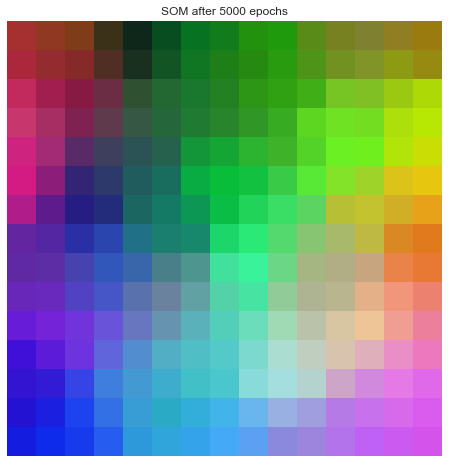

In [13]:
dataset = np.random.randint(0, 256, (100, 3))

som = SOM(map_side=15, input_dim=3, learning_rate=0.4, neighborhood=7)
som.train(dataset, epochs=5000, show_progress=True, interval=1000)

#### 2D SOM

What if we tried a 2D SOM? Let's see what happens if we use our map with points from a 2D circle:

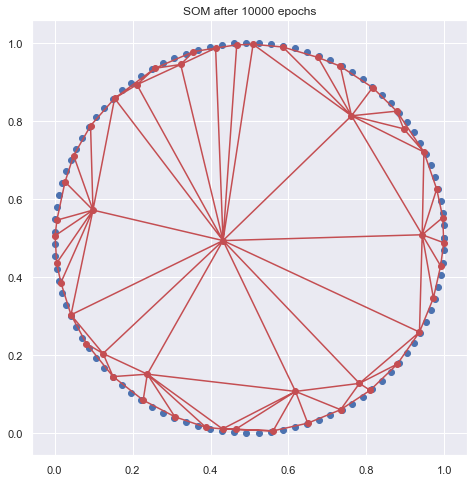

In [14]:
theta = np.linspace(0, 2*np.pi, 100)
a, b = np.cos(theta), np.sin(theta)
dataset = np.array(list(zip(a, b)))

som2d = SOM(map_side=7, input_dim=2, neighborhood=0.5, learning_rate=0.4)
som2d.train(dataset, epochs=10000, interval=2000)

### Further reading and questions

When training neural networks we use metrics such as loss and accuracy to measure their performance. How would you measure a SOM's performance?

How do we dedice which hyperparameters are better for our SOM and our dataset? How many units should it have? What about the learning rate?